In [1]:
import gzip
import json
import pickle
import scipy.sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import spatial
from tqdm.auto import tqdm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

In [2]:
THREADS = 8

In [3]:
model = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/warp_model_1000_epochs_slim.pkl')

## Precision

In [6]:
interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/lightfm_data/slim_interactions.npz')

In [ ]:
# Super time-consuming: https://github.com/lyst/lightfm/issues/510
precision_at_k(model, interactions, k=5, num_threads=THREADS).mean()

## ABX utils

In [30]:
def analyse_ABX(path, tsne = None, pca = None):
    abx_tests = pd.read_json(path, lines=True)
    A = np.zeros((10000, 100))
    B = np.zeros((10000, 100))
    X = np.zeros((10000, 100))

    for i, test in tqdm(abx_tests.iterrows()):
        A[i, :] = items_embeddings.loc[test["A"]]
        B[i, :] = items_embeddings.loc[test["B"]]
        X[i, :] = items_embeddings.loc[test["X"]]

    dist_A = ((A - X)**2).sum(axis=1)
    dist_B = ((B - X)**2).sum(axis=1)

    cos_dist_A = np.zeros(10000)
    cos_dist_B = np.zeros(10000)

    for i in tqdm(range(10000)):
        cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
        cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

    if pca is not None:
        pca_A = pca.transform(A)
        pca_B = pca.transform(B)
        pca_X = pca.transform(X)

        dist_pca_A = ((pca_A - pca_X)**2).sum(axis=1)
        dist_pca_B  = ((pca_B - pca_X)**2).sum(axis=1)

        cos_dist_pca_A = np.zeros(10000)
        cos_dist_pca_B = np.zeros(10000)

        for i in tqdm(range(10000)):
            cos_dist_pca_A[i] = spatial.distance.cosine(pca_A[i, :], pca_X[i, :])
            cos_dist_pca_B[i] = spatial.distance.cosine(pca_B[i, :], pca_X[i, :])

    if tsne is not None:
        tsne_A = np.zeros((10000, 2))
        tsne_B = np.zeros((10000, 2))
        tsne_X = np.zeros((10000, 2))

        for i, test in tqdm(abx_tests.iterrows()):
            tsne_A[i, :] = tsne.loc[test["A"]]
            tsne_B[i, :] = tsne.loc[test["B"]]
            tsne_X[i, :] = tsne.loc[test["X"]]


        dist_tsne_A = ((tsne_A - tsne_X)**2).sum(axis=1)
        dist_tsne_B  = ((tsne_B - tsne_X)**2).sum(axis=1)

        cos_dist_tsne_A = np.zeros(10000)
        cos_dist_tsne_B = np.zeros(10000)

        for i in tqdm(range(10000)):
            cos_dist_tsne_A[i] = spatial.distance.cosine(tsne_A[i, :], tsne_X[i, :])
            cos_dist_tsne_B[i] = spatial.distance.cosine(tsne_B[i, :], tsne_X[i, :])

    print("Eucl:")
    print("Score: ", (dist_A < dist_B).mean())
    if pca is not None:
        print("PCA score: ", (dist_pca_A < dist_pca_B).mean())
        print("PCA distance match: ", ((dist_A < dist_B) == (dist_pca_A < dist_pca_B)).mean())
    if tsne is not None:
        print("tSNE score: ", (dist_tsne_A < dist_tsne_B).mean())
        print("tSNE distance match: ", ((dist_A < dist_B) == (dist_tsne_A < dist_tsne_B)).mean())

    print("Cos:",)
    print("Score: ", (cos_dist_A < cos_dist_B).mean())
    if pca is not None:
        print("PCA score: ", (cos_dist_pca_A < cos_dist_pca_B).mean())
        print("PCA distance match: ", ((cos_dist_A < cos_dist_B) == (cos_dist_pca_A < cos_dist_pca_B)).mean())
    if tsne is not None:
        print("tSNE score: ", (cos_dist_tsne_A < cos_dist_tsne_B).mean())
        print("tSNE distance match: ", ((cos_dist_A < cos_dist_B) == (cos_dist_tsne_A < dist_tsne_B)).mean())

In [4]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/slim_dataset.pkl')

item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
items_embeddings = pd.DataFrame(model.item_embeddings)
items_embeddings = items_embeddings.rename(index=item_mapping)

tsne = np.load('/pio/scratch/1/i313924/data/lightfm_data/tsne_embeddings_1000_epochs_slim.npy')

tsne = pd.DataFrame(tsne)
tsne = tsne.rename(index=item_mapping)

user_embeddings = pd.DataFrame(model.user_embeddings)
embeddings = pd.concat([items_embeddings, user_embeddings], keys=['items', 'users'])
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

## ABX (only popular)

In [31]:
analyse_ABX('/pio/scratch/1/i313924/data/test_data/test_ABX_weighted_slim.json', pca=pca, tsne=tsne)

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Eucl:
Score:  0.5278
PCA score:  0.5894
PCA distance match:  0.5624
tSNE score:  0.5937
tSNE distance match:  0.5621
Cos:
Score:  0.5709
PCA score:  0.5914
PCA distance match:  0.6489
tSNE score:  0.6001
tSNE distance match:  0.5717


## Suits & dresses ABX

In [32]:
analyse_ABX('/pio/scratch/1/i313924/data/test_data/Suits_Dresses_ABX.json', pca=pca, tsne=tsne)

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Eucl:
Score:  0.5124
PCA score:  0.542
PCA distance match:  0.5546
tSNE score:  0.5189
tSNE distance match:  0.5231
Cos:
Score:  0.5321
PCA score:  0.5408
PCA distance match:  0.6339
tSNE score:  0.5309
tSNE distance match:  0.5331


## Embeddings PCA

In [14]:
reduced_item_embeddings = pd.DataFrame(pca.transform(embeddings.loc["items"]))
reduced_user_embeddings = pd.DataFrame(pca.transform(embeddings.loc["users"]))

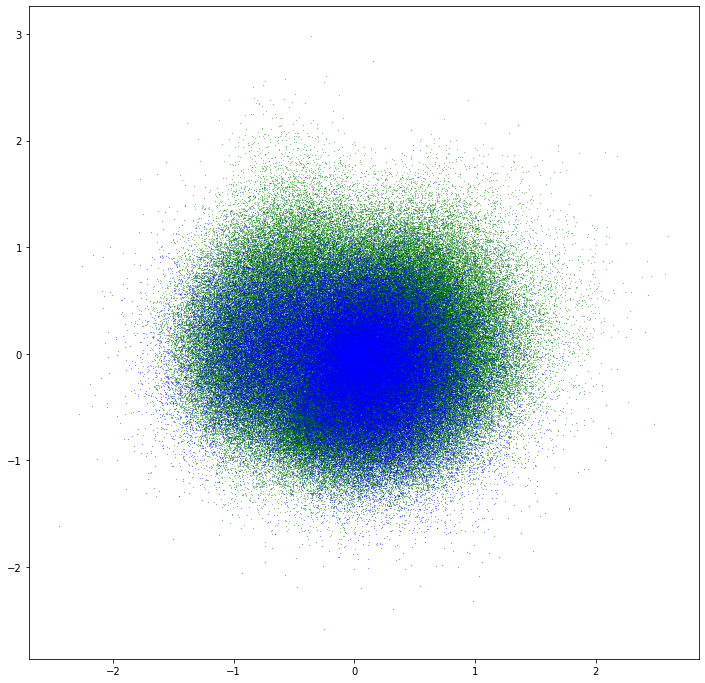

In [15]:
plt.figure(figsize=(12, 12))
plt.scatter(reduced_item_embeddings[0], reduced_item_embeddings[1], c='green', s=0.03)
plt.scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], c='blue', s=0.03)

In [17]:
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
user_mapping = {v: k for k, v in dataset.mapping()[0].items()}

In [18]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [19]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [20]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [46]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

/pio/scratch/1/i313924/miniconda3/envs/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


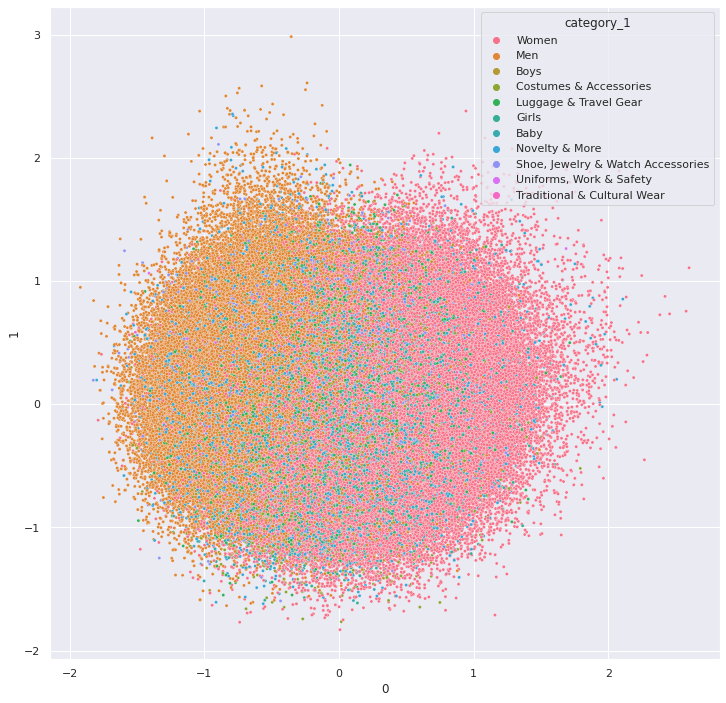

In [25]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

<AxesSubplot:xlabel='0', ylabel='1'>

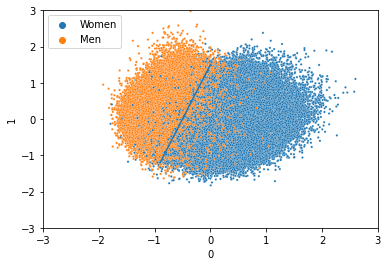

In [233]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=5).set(xlim=(-3,3),ylim=(-3,3))
# y = 3x + 1.5
sns.lineplot(x=[-0.9, 0], y=[-1.2, 1.5])

<AxesSubplot:xlabel='0', ylabel='1'>

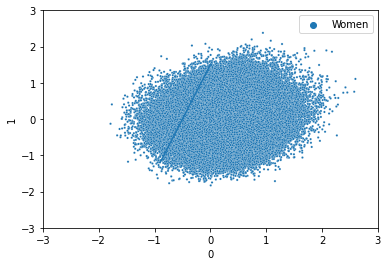

In [167]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women'])], hue='category_1', s=5).set(xlim=(-3,3),ylim=(-3,3))
sns.lineplot(x=[-0.9, 0], y=[-1.2, 1.5])

<AxesSubplot:xlabel='0', ylabel='1'>

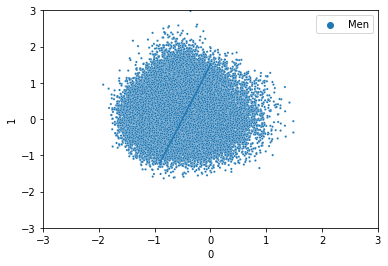

In [168]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin([ 'Men'])], hue='category_1', s=5).set(xlim=(-3,3),ylim=(-3,3))
sns.lineplot(x=[-0.9, 0], y=[-1.2, 1.5])

In [153]:
women_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Women']
men_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Men']

In [155]:
left_women = women_embeddings[3*women_embeddings['0'] + 1.5 < women_embeddings['1']]
right_women = women_embeddings[3*women_embeddings['0'] + 1.5 > women_embeddings['1']]

In [156]:
left_men = men_embeddings[3*men_embeddings['0'] + 1.5 < men_embeddings['1']]
right_men = men_embeddings[3*men_embeddings['0'] + 1.5 > men_embeddings['1']]

In [162]:
len(left_women)/len(women_embeddings) * 100

5.625569166593226

In [163]:
len(right_men)/len(men_embeddings) * 100

34.33380574268575

0it [00:00, ?it/s]

[(-3.0, 3.0), (-3.0, 3.0)]

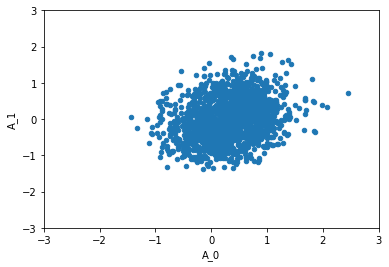

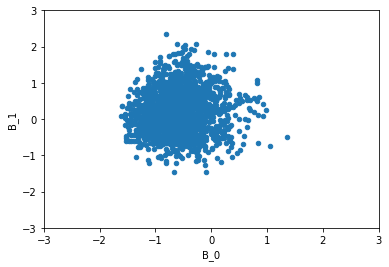

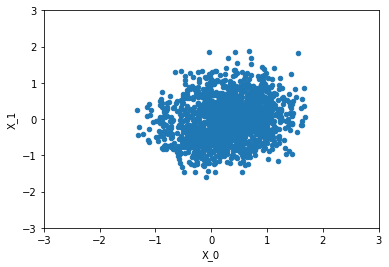

In [228]:
reduced_item_embeddings = reduced_item_embeddings.drop_duplicates()

l = []
for i, test in tqdm(abx_tests.iterrows()):
    if test["category_AX"] == "Women" and test["category_B"] == "Men":
        line = {
            "A_0":reduced_item_embeddings.loc[test["A"]]['0'],
            "A_1":reduced_item_embeddings.loc[test["A"]]['1'],
            "B_0":reduced_item_embeddings.loc[test["B"]]['0'],
            "B_1":reduced_item_embeddings.loc[test["B"]]['1'],
            "X_0": reduced_item_embeddings.loc[test["X"]]['0'],
            "X_1":reduced_item_embeddings.loc[test["X"]]['1'],

        }
        l.append(line)

scattered_abx = pd.DataFrame(l)

scattered_abx.plot.scatter(x="A_0", y="A_1").set(xlim = (-3,3), ylim=(-3, 3))
scattered_abx.plot.scatter(x="B_0", y="B_1").set(xlim = (-3,3), ylim=(-3, 3))
scattered_abx.plot.scatter(x="X_0", y="X_1").set(xlim = (-3,3), ylim=(-3, 3))

0it [00:00, ?it/s]

[(-3.0, 3.0), (-3.0, 3.0)]

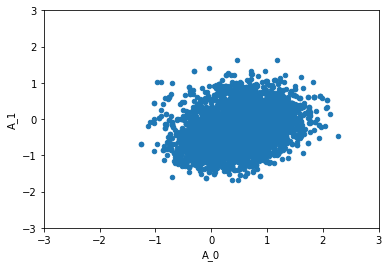

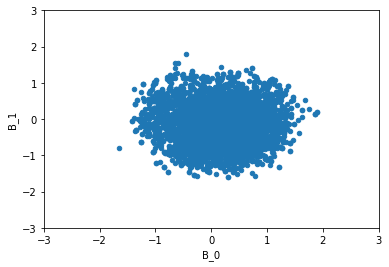

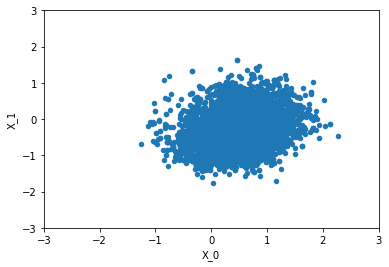

In [230]:
reduced_item_embeddings = reduced_item_embeddings.drop_duplicates()

l = []
for i, test in tqdm(abx_tests_sd.iterrows()):
    if test["category_AX"] == "Women" and test["category_B"] == "Men":
        line = {
            "A_0":reduced_item_embeddings.loc[test["A"]]['0'],
            "A_1":reduced_item_embeddings.loc[test["A"]]['1'],
            "B_0":reduced_item_embeddings.loc[test["B"]]['0'],
            "B_1":reduced_item_embeddings.loc[test["B"]]['1'],
            "X_0": reduced_item_embeddings.loc[test["X"]]['0'],
            "X_1":reduced_item_embeddings.loc[test["X"]]['1'],

        }
        l.append(line)

scattered_abx = pd.DataFrame(l)

scattered_abx.plot.scatter(x="A_0", y="A_1").set(xlim = (-3,3), ylim=(-3, 3))
scattered_abx.plot.scatter(x="B_0", y="B_1").set(xlim = (-3,3), ylim=(-3, 3))
scattered_abx.plot.scatter(x="X_0", y="X_1").set(xlim = (-3,3), ylim=(-3, 3))

## KNN

In [193]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4)

In [194]:
samples = reduced_item_embeddings[['0', '1']].to_numpy()

In [195]:
neigh.fit(samples)

NearestNeighbors(n_neighbors=4)

In [203]:
women_nns = {}
for i in tqdm(range(len(women_embeddings))):
    women_nns[i] = reduced_item_embeddings.iloc[neigh.kneighbors(women_embeddings[['0', '1']].to_numpy()[i, :].reshape(1, -1))[1][0][1:]]['category_1'].values

  0%|          | 0/102123 [00:00<?, ?it/s]

In [211]:
women_not_nearest = 0
for _, v in women_nns.items():
    u, c = np.unique(v, return_counts=True)
    women_count = dict(zip(u, c)).get('Women')
    if women_count is None or women_count < 2:
        women_not_nearest += 1

In [216]:
women_not_nearest / len(women_embeddings) * 100

33.50665374107694

In [214]:
men_nearest = 0
for _, v in women_nns.items():
    u, c = np.unique(v, return_counts=True)
    men_count = dict(zip(u, c)).get('Men')
    if men_count is not None and men_count >= 2:
        men_nearest += 1

In [215]:
men_nearest / len(women_embeddings) * 100

7.458652801034048

In [218]:
men_nns = {}
for i in tqdm(range(len(men_embeddings))):
    men_nns[i] = reduced_item_embeddings.iloc[neigh.kneighbors(men_embeddings[['0', '1']].to_numpy()[i, :].reshape(1, -1))[1][0][1:]]['category_1'].values

  0%|          | 0/51509 [00:00<?, ?it/s]

In [219]:
men_not_nearest = 0
for _, v in men_nns.items():
    u, c = np.unique(v, return_counts=True)
    men_count = dict(zip(u, c)).get('Men')
    if men_count is None or men_count < 2:
        men_not_nearest += 1

In [220]:
men_not_nearest / len(men_embeddings) * 100

42.837174086082044

In [221]:
women_nearest = 0
for _, v in men_nns.items():
    u, c = np.unique(v, return_counts=True)
    women_count = dict(zip(u, c)).get('Women')
    if women_count is not None and women_count >= 2:
        women_nearest += 1

In [222]:
women_nearest / len(men_embeddings) * 100

18.14246054087635

## tSNE

In [7]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [8]:
tsne = np.load('/pio/scratch/1/i313924/data/lightfm_data/tsne_embeddings_1000_epochs_slim.npy')
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/slim_dataset.pkl')

item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
tsne = pd.DataFrame(tsne)
tsne = tsne.rename(index=item_mapping)

In [10]:
tsne = tsne.join(categories.set_index('asin'))

In [11]:
tsne.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

/pio/scratch/1/i313924/miniconda3/envs/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


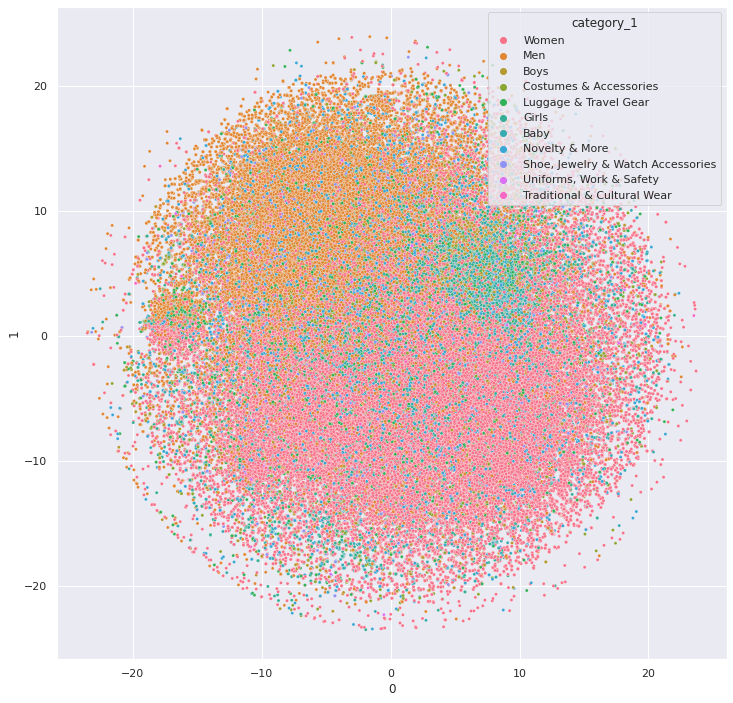

In [12]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=tsne, hue='category_1', s=10)

<AxesSubplot:xlabel='0', ylabel='1'>

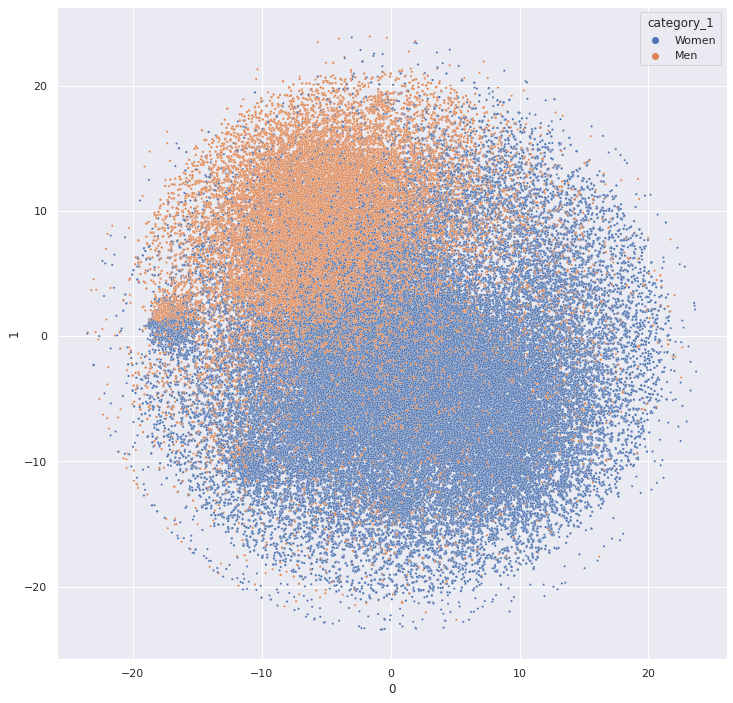

In [13]:
sns.scatterplot(x='0', y='1', data=tsne[tsne['category_1'].isin(['Women', 'Men'])], hue='category_1', s=5)

In [19]:
tsne[(tsne["0"] < -12) & (tsne["0"] > -20) & (tsne["1"] > -1) & (tsne["1"] < 3)].drop_duplicates()

,0,1,category_1,category_2
B00004U3LH,-13.163000,1.970270,Costumes & Accessories,Men
B00004U3SS,-13.168001,1.981498,Costumes & Accessories,Men
B00008KH9C,-18.322990,-0.336189,Women,Clothing
B00009EPE7,-17.039055,1.180317,Costumes & Accessories,Kids & Baby
B0000B35DA,-14.316576,-0.684569,Women,Jewelry
...,...,...,...,...
B01HIATE6A,-17.013052,0.915943,Luggage & Travel Gear,Luggage
B01HIATF82,-16.990185,1.067833,Luggage & Travel Gear,Luggage
B01HISUIZ8,-12.639745,1.840854,Women,Clothing
B01HIXPET8,-17.146437,1.336692,Girls,Shoes
